In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, random_split
import re
import random
from collections import Counter
import pickle
from torch.nn.parallel import DataParallel
import pandas as pd

In [2]:
def create_dataset(sequences, word_to_idx):
    """Create input and target tensors from word sequences"""
    input_seqs = []
    targets = []

    for sequence in sequences:
        input_seq = [word_to_idx.get(word, word_to_idx['<UNK>']) for word in sequence[:-1]]
        target = word_to_idx.get(sequence[-1], word_to_idx['<UNK>'])
        input_seqs.append(torch.tensor(input_seq, dtype=torch.long))
        targets.append(torch.tensor(target, dtype=torch.long))


    padded_inputs = pad_sequence(input_seqs, batch_first=True, padding_value=0)
    targets_tensor = torch.stack(targets)

    return TensorDataset(padded_inputs, targets_tensor)

In [3]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                           batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        # Output layer
        self.fc = nn.Linear(hidden_dim, vocab_size)
    def forward(self, x):
        # x shape: (batch_size, sequence_length)
        batch_size = x.size(0)
        # Embedding
        embedded = self.embedding(x)
        # LSTM
        lstm_out, (hidden, cell) = self.lstm(embedded)
        last_output = lstm_out[:, -1, :]
        dropped = self.dropout(last_output)
        # Final linear layer
        output = self.fc(dropped)  # (batch_size, vocab_size)

        return output

In [4]:
#@title don't show code till dblclick
@hide_
normalize_dict = {
    # Religious/Common expressions
    ('aameen', 'ameen', 'amin'): 'ameen',
    ('allah', 'allaah', 'ala', 'alah'): 'allah',
    ('inshallah', 'insha allah', 'inshaallah', 'inshaAlah'): 'inshallah',
    ('mashallah', 'masha allah', 'mashaallah', 'mashaAlah'): 'mashallah',
    ('subhanallah', 'subhan allah', 'subhanAlah'): 'subhanallah',
    ('bismillah', 'bismilah', 'bismilaah'): 'bismillah',
    ('alhamdulillah', 'alhamdulilah', 'alhamdulillaah'): 'alhamdulillah',

    # Curse words/negative expressions
    ('lanut', 'lanat', 'lanaat', 'lannat', 'lanet', 'laanat'): 'lanat',
    ('beghairat', 'beghairt', 'begharat', 'begherat', 'beghrato', 'beghaurt', 'beghrti', 'beghert', 'beghart', 'beghairto', 'baghairat', 'begharat'): 'beghairat',
    ('badtameez', 'badtamez', 'badtamiz', 'badtmeez'): 'badtameez',
    ('ganda', 'gnda', 'gndaa', 'gandaa'): 'ganda',
    ('kharab', 'kharap', 'khrb', 'khrab'): 'kharab',
    ('pagal', 'pagl', 'pgl', 'pagaal', 'paagal'): 'pagal',
    ('bakwass', 'bakwas', 'bakvaas', 'bakvaaz', 'bakvas'): 'bakwas',
    ('chup', 'chupchap', 'chup!', 'choop'): 'chup',
    ('jhoot', 'jhut', 'jhooot', 'jhuut'): 'jhoot',
    ('kameena', 'kamina', 'kameenaa', 'kaminaa'): 'kameena',

    # Basic words and numbers
    ('ek', 'aik', 'ak', 'eik', 'ik', 'aek'): 'aik',
    ('do', 'doo', 'dou'): 'do',
    ('teen', 'tin', 'tiin'): 'teen',
    ('char', 'chaar', 'chr'): 'char',
    ('panch', 'paanch', 'pnch'): 'panch',
    ('che', 'chhe', 'chay'): 'che',
    ('saat', 'sat', 'saath'): 'saat',
    ('aath', 'ath', 'aanth'): 'aath',
    ('nau', 'no', 'now'): 'nau',
    ('das', 'dus', 'duss'): 'das',

    # Common verbs
    ('lagta', 'lagty', 'laghta', 'lagta', 'lagtaa'): 'lagta',
    ('dekh', 'dekho', 'dekhta', 'daikh', 'daykh', 'dekhtaa', 'dekhna'): 'dekh',
    ('sun', 'suno', 'sunna', 'sunta', 'sunn', 'sunnaa'): 'sun',
    ('ja', 'jaye', 'jao', 'jata', 'jaata', 'jaa', 'jaana'): 'ja',
    ('aaja', 'aao', 'aa', 'aaye', 'aati', 'ata', 'aata', 'aana'): 'aa',
    ('karo', 'karo.', 'karen', 'karnay', 'kra', 'krna', 'karna', 'kro', 'krnaa'): 'karo',
    ('liya', 'lia', 'liye', 'liy', 'leya', 'liyea', 'lena', 'lnaa'): 'liye',
    ('diya', 'dia', 'diye', 'diy', 'deya', 'diyea', 'dena', 'dnaa'): 'diye',
    ('gaya', 'gia', 'gya', 'geya', 'gayaa', 'jana'): 'gaya',
    ('aya', 'aia', 'ayaa', 'aayaa', 'aana'): 'aya',
    ('kya', 'kia', 'kyaa', 'kiaa'): 'kya',
    ('ho', 'hoo', 'hona', 'hnaa'): 'ho',
    ('kar', 'kr', 'krr'): 'kar',
    ('ban', 'bann', 'banna', 'bnaa'): 'ban',
    ('mil', 'mill', 'milna', 'mlnaa'): 'mil',
    ('chal', 'chall', 'chalna', 'chlnaa'): 'chal',
    ('rakh', 'rakhna', 'rkhnaa'): 'rakh',
    ('le', 'lay', 'laye'): 'le',
    ('de', 'day', 'daye'): 'de',
    ('pel', 'maar', 'mr', 'marna', 'mrnaa'): 'maar',
    ('khel', 'khelna', 'khlnaa'): 'khel',
    ('padh', 'padhna', 'prhnaa', 'parhna'): 'padh',
    ('likh', 'likhna', 'lkhnaa'): 'likh',
    ('samjh', 'samajh', 'samjhna', 'smjhnaa'): 'samjh',
    ('baat', 'bt', 'bta', 'batana', 'btana'): 'baat',
    ('keh', 'kehna', 'khnaa'): 'keh',
    ('bol', 'bolna', 'blnaa'): 'bol',

    # Pronouns and common particles
    ('ne', 'ny', 'nyy', 'nay'): 'ny',
    ('ky', 'ki', 'ke', 'kay', 'kee'): 'ki',
    ('ko', 'koo', 'ku'): 'ko',
    ('ka', 'kaa', 'kay'): 'ka',
    ('se', 'sy', 'say'): 'se',
    ('pe', 'py', 'pay', 'par'): 'pe',
    ('mein', 'main', 'ma', 'mei', 'mayn', 'me'): 'mein',
    ('per', 'pr', 'prr'): 'per',
    ('tak', 'tk', 'takk'): 'tak',
    ('wala', 'wla', 'walaa', 'waala'): 'wala',
    ('wali', 'wli', 'walii', 'waali'): 'wali',
    ('walay', 'wley', 'waale'): 'walay',

    # Negation
    ('nahi', 'ni', 'nai', 'nhe', 'nahe', 'nahin', 'nhi', 'nah', 'nahee'): 'ni',
    ('na', 'naa', 'nah'): 'na',
    ('mat', 'mt', 'matt'): 'mat',
    ('kuch', 'kch', 'kuchh'): 'kuch',
    ('koi', 'koii', 'koy'): 'koi',

    # Pronouns
    ('aap', 'ap', 'ep', 'aapp'): 'aap',
    ('tum', 'tm', 'tumhe', 'tumhein', 'tumhy', 'tumko', 'tumhey'): 'tum',
    ('hum', 'hm', 'ham', 'humlog', 'humm'): 'hum',
    ('mujhy', 'mujhe', 'mujha', 'mujhay', 'moje', 'mojhe', 'mojhy', 'muje', 'mujhey'): 'mujhy',
    ('tumhey', 'tumhe', 'tumhein', 'tumhy', 'tumhay'): 'tumhey',
    ('usko', 'usy', 'use', 'usey', 'usk'): 'usko',
    ('hamey', 'hame', 'hamein', 'hamy', 'hamay'): 'hamey',
    ('wo', 'woh', 'voh', 'vo'): 'wo',
    ('ye', 'yeh', 'yay', 'ya'): 'ye',
    ('is', 'iss', 'isk', 'iski', 'iska'): 'is',
    ('us', 'uss', 'usk', 'uski', 'uska'): 'us',
    ('in', 'inn', 'inki', 'inka'): 'in',
    ('un', 'unn', 'unki', 'unka'): 'un',

    # Common words
    ('waja', 'wajah', 'wja', 'wajh'): 'wajah',
    ('waqt', 'waqat', 'wqt', 'wakt', 'wqat'): 'waqt',
    ('to', 'tuo', 'tou', 'too'): 'to',
    ('th', 'tha', 'tha.', 'thaa'): 'tha',
    ('thy', 'the', 'thay', 'thay'): 'thy',
    ('thi', 'thee', 'thii'): 'thi',
    ('bohot', 'bohtt', 'buhat', 'bohat', 'bohet', 'boht', 'bhoot', 'bhut', 'bht'): 'bohat',
    ('kyun', 'kyu', 'kyon', 'kyoon', 'kyoo', 'kyuun'): 'kyu',
    ('kahan', 'kha', 'kahaan', 'khn'): 'kahan',
    ('kab', 'kb', 'kabb'): 'kab',
    ('kaise', 'kese', 'kyse', 'kaisay'): 'kaise',
    ('kitna', 'kitne', 'kitni', 'ktnaa'): 'kitna',
    ('kaun', 'kon', 'konn', 'koon'): 'kaun',
    ('kiski', 'kiska', 'kiske', 'ksk'): 'kiski',
    ('jab', 'jb', 'jabb'): 'jab',
    ('jahan', 'jha', 'jahaan', 'jhn'): 'jahan',
    ('jaise', 'jese', 'jyse', 'jaisay'): 'jaise',
    ('aise', 'ese', 'yse', 'aisay'): 'aise',
    ('waise', 'wese', 'wyse', 'waisay'): 'waise',
    ('agar', 'agr', 'agrr'): 'agar',
    ('lekin', 'lekn', 'lkn', 'magar', 'mgr'): 'lekin',
    ('phir', 'phr', 'firr'): 'phir',
    ('ab', 'abhi', 'abb', 'abhii'): 'ab',
    ('pehle', 'phle', 'pehlay', 'phlay'): 'pehle',
    ('baad', 'bd', 'badd'): 'baad',
    ('saath', 'sath', 'saathh'): 'saath',
    ('bina', 'bagher', 'bghair'): 'bina',
    ('andar', 'andrr', 'andr'): 'andar',
    ('bahar', 'bahr', 'bahrr'): 'bahar',
    ('upar', 'upr', 'uprr'): 'upar',
    ('neeche', 'neche', 'niche'): 'neeche',
    ('paas', 'pas', 'pass'): 'paas',
    ('door', 'dur', 'durr'): 'door',
    ('paas', 'pas', 'pass'): 'paas',
    ('samne', 'samny', 'samnay'): 'samne',
    ('peeche', 'peche', 'piche'): 'peeche',
    ('beech', 'bech', 'bich'): 'beech',
    ('bich', 'beech', 'bech'): 'bich',

    # Greetings and expressions
    ('helo', 'hallo', 'halo', 'helloo', 'heloo', 'hellow'): 'hello',
    ('assalam', 'asalam', 'assalaam', 'aslam'): 'assalam',
    ('walaikum', 'walikum', 'walekum', 'waleikum'): 'walaikum',
    ('adaab', 'adab', 'aadaab'): 'adaab',
    ('namaste', 'namasty', 'namastey'): 'namaste',
    ('khuda', 'khudaa', 'khda'): 'khuda',
    ('hafiz', 'hafez', 'haafiz'): 'hafiz',
    ('alvida', 'alwida', 'alvidaa'): 'alvida',
    ('tata', 'ta ta', 'byebye', 'bye bye'): 'bye',

    # Emotions and expressions
    ('haan', 'han', 'ha', 'haa', 'haan.', 'haanji', 'hanji'): 'haan',
    ('hahaha', 'haha', 'hahahaha', 'hahahah', 'hahahahh', 'hahahhah', 'hahhaha', 'ahahah', 'haahha', 'hahahahha', 'haahahah', 'hehe', 'hehehe'): 'haha',
    ('wow', 'waow', 'waoow', 'wah', 'wahh'): 'wow',
    ('oh', 'ooh', 'ohh', 'oohh'): 'oh',
    ('are', 'arey', 'arree', 'ary'): 'are',
    ('wah', 'wahh', 'waahh'): 'wah',
    ('shukr', 'shukar', 'shukur'): 'shukr',
    ('khushi', 'khshi', 'kushi'): 'khushi',
    ('gham', 'ghm', 'gumm'): 'gham',
    ('dukh', 'dkh', 'dukhh'): 'dukh',
    ('sukh', 'skh', 'sukhh'): 'sukh',
    ('pyar', 'pyr', 'pyaar'): 'pyar',
    ('mohabbat', 'mohabat', 'muhabbat'): 'mohabbat',
    ('nafrat', 'nfrat', 'nafraat'): 'nafrat',
    ('gussa', 'gusa', 'gussaa'): 'gussa',
    ('sharam', 'shrm', 'sharaam'): 'sharam',
    ('izzat', 'izat', 'izzaat'): 'izzat',

    # Adjectives
    ('sahi', 'sach', 'theek', 'thk', 'thik'): 'sahi',
    ('galat', 'glt', 'glt.', 'ghalat', 'ghalaat'): 'galat',
    ('acha', 'achha', 'acha.', 'acha!', 'acha?', 'achaa'): 'acha',
    ('bura', 'buraa', 'bra', 'brra', 'braa'): 'bura',
    ('sundar', 'sundr', 'khubsurat', 'khubsrt'): 'sundar',
    ('badsurat', 'badsrt', 'badsoorat'): 'badsurat',
    ('bari', 'barri', 'baree', 'bare', 'bara', 'baraa'): 'bari',
    ('choti', 'chhoti', 'chotee', 'choty', 'chota', 'chotaa'): 'choti',
    ('lamba', 'lmba', 'lambaa'): 'lamba',
    ('chota', 'chta', 'chotaa'): 'chota',
    ('mota', 'mta', 'motaa'): 'mota',
    ('dubla', 'dbla', 'dublaa'): 'dubla',
    ('gora', 'gra', 'goraa'): 'gora',
    ('kala', 'kla', 'kalaa'): 'kala',
    ('safed', 'sfd', 'saafed'): 'safed',
    ('kala', 'kla', 'kalaa'): 'kala',
    ('lal', 'laal', 'll'): 'lal',
    ('neela', 'nila', 'neelaa'): 'neela',
    ('peela', 'pila', 'peelaa'): 'peela',
    ('hara', 'hra', 'haraa'): 'hara',
    ('naya', 'nya', 'nayaa'): 'naya',
    ('purana', 'prana', 'puraanaa'): 'purana',
    ('taza', 'tza', 'taazaa'): 'taza',
    ('garam', 'grm', 'garaam'): 'garam',
    ('thanda', 'thnda', 'thandaa'): 'thanda',
    ('meetha', 'mitha', 'meethaaa'): 'meetha',
    ('namkeen', 'nmkeen', 'namkeeen'): 'namkeen',
    ('khatta', 'khta', 'khattaa'): 'khatta',
    ('karwa', 'krwa', 'karwaa'): 'karwa',
    ('asaan', 'asan', 'aasaan'): 'asaan',
    ('mushkil', 'mshkil', 'mushkill'): 'mushkil',
    ('sasta', 'ssta', 'sastaa'): 'sasta',
    ('mehenga', 'mhenga', 'mehengaa'): 'mehenga',

    # Family relations
    ('bhai', 'bhaii', 'bahi', 'bhae', 'bhy', 'bhaai'): 'bhai',
    ('behan', 'bhen', 'bahin', 'behaan'): 'behan',
    ('maa', 'ma', 'ama', 'amma', 'ammi', 'amaa'): 'maa',
    ('baap', 'bap', 'abu', 'abba', 'abbu', 'baapp'): 'baap',
    ('beta', 'bta', 'betaa'): 'beta',
    ('beti', 'bti', 'betii'): 'beti',
    ('nana', 'nna', 'nanaa'): 'nana',
    ('nani', 'nni', 'naani'): 'nani',
    ('dada', 'dda', 'dadaa'): 'dada',
    ('dadi', 'ddi', 'daadi'): 'dadi',
    ('chacha', 'chcha', 'chachaa'): 'chacha',
    ('chachi', 'chchi', 'chaachii'): 'chachi',
    ('mama', 'mma', 'mamaa'): 'mama',
    ('mami', 'mmi', 'maami'): 'mami',
    ('phuppa', 'phpa', 'phuppaa'): 'phuppa',
    ('phuppi', 'phpi', 'phuppii'): 'phuppi',
    ('khaloo', 'khlu', 'khaluu'): 'khaloo',
    ('khala', 'khla', 'khalaa'): 'khala',

    # Time and days
    ('din', 'dn', 'dinn'): 'din',
    ('raat', 'rat', 'raatt'): 'raat',
    ('subah', 'sbah', 'subaah'): 'subah',
    ('shaam', 'sham', 'shaam'): 'shaam',
    ('dopahar', 'dophar', 'dopahaar'): 'dopahar',
    ('peer', 'pir', 'peer'): 'peer',
    ('mangal', 'mngal', 'mangaal'): 'mangal',
    ('budh', 'bdh', 'budhh'): 'budh',
    ('jumerat', 'jmerat', 'jumeraat'): 'jumerat',
    ('juma', 'jma', 'jumaa'): 'juma',
    ('hafta', 'hfta', 'haftaa'): 'hafta',
    ('mahina', 'mhina', 'mahinaa'): 'mahina',
    ('saal', 'sal', 'saall'): 'saal',
    ('aaj', 'aj', 'aajj'): 'aaj',
    ('kal', 'kl', 'kall'): 'kal',
    ('parso', 'prso', 'parsoo'): 'parso',
    ('tarso', 'trso', 'tarsoo'): 'tarso',

    # Food and eating
    ('khana', 'khna', 'khaanaa'): 'khana',
    ('pani', 'pni', 'paani'): 'pani',
    ('dudh', 'ddh', 'dudhh'): 'dudh',
    ('chai', 'chy', 'chaai'): 'chai',
    ('roti', 'rti', 'rotii'): 'roti',
    ('chawal', 'chwal', 'chaawaal'): 'chawal',
    ('daal', 'dal', 'daall'): 'daal',
    ('sabzi', 'sbzi', 'sabzii'): 'sabzi',
    ('gosht', 'gsht', 'goshtt'): 'gosht',
    ('machli', 'mchli', 'machlii'): 'machli',
    ('anda', 'nda', 'andaa'): 'anda',
    ('phal', 'phl', 'phall'): 'phal',
    ('mithai', 'mthai', 'mithaaai'): 'mithai',
    ('halwa', 'hlwa', 'halwaa'): 'halwa',

    # Misc common words
    ('mazay', 'maza', 'mazaa', 'mza', 'maazaa'): 'maza',
    ('zindagi', 'zindgy', 'zindgi', 'zindagee', 'zindagii'): 'zindagi',
    ('jaldi', 'jldi', 'jaldi.', 'jaldi!', 'jaldii'): 'jaldi',
    ('dheere', 'dhire', 'dheery', 'dheerey'): 'dheere',
    ('shukriya', 'shukria', 'shukriyaa'): 'shukriya',
    ('maaf', 'maf', 'maff'): 'maaf',
    ('karo', 'kro', 'karoo'): 'karo',
    ('please', 'plz', 'pls', 'plees'): 'please',
    ('sorry', 'sry', 'sorri'): 'sorry',
    ('thanks', 'thnx', 'thx', 'thanx'): 'thanks',
    ('welcome', 'welcum', 'welcom'): 'welcome',
    ('yes', 'ys', 'yess'): 'yes',
    ('no', 'noo', 'noh'): 'no',
    ('ok', 'okay', 'oky', 'ookay'): 'ok',
    ('bas', 'bs', 'bass'): 'bas',
    ('sirf', 'srf', 'sirff'): 'sirf',
    ('bilkul', 'bilkl', 'bilkull'): 'bilkul',
    ('zaroor', 'zarur', 'zaroorr'): 'zaroor',
    ('shayad', 'shyd', 'shayaad'): 'shayad',
    ('yaqeen', 'yqeen', 'yaqeeen'): 'yaqeen',
    ('umeed', 'umid', 'umeeeed'): 'umeed',
    ('intezar', 'intizar', 'intezaar'): 'intezar',
    ('khabar', 'khbr', 'khabr'): 'khabar',
    ('baat', 'bt', 'baatt'): 'baat',
    ('kaam', 'kam', 'kaamm'): 'kaam',
    ('paisa', 'pesa', 'paisaa'): 'paisa',
    ('ghar', 'ghr', 'gharr'): 'ghar',
    ('school', 'skool', 'scool'): 'school',
    ('college', 'coleg', 'colege'): 'college',
    ('office', 'ofis', 'ofice'): 'office',
    ('hospital', 'hosptal', 'hospitaal'): 'hospital',
    ('dukaan', 'dukan', 'dukaann'): 'dukaan',
    ('market', 'markt', 'markeet'): 'market',
    ('station', 'steshn', 'statioon'): 'station',
    ('gaari', 'gari', 'gaarii'): 'gaari',
    ('bus', 'bs', 'buss'): 'bus',
    ('train', 'tren', 'trainn'): 'train',
    ('hawa', 'hwa', 'hawaa'): 'hawa',
    ('badal', 'bdl', 'badall'): 'badal',
    ('barish', 'brish', 'barissh'): 'barish',
    ('dhoop', 'dhup', 'dhooop'): 'dhoop',
    ('taariq', 'tariq', 'taariiq'): 'tariq',
    ('chehra', 'chehra', 'chehrah'): 'chehra',
    ('aankhein', 'ankhein', 'aankhen'): 'aankhein',
    ('haath', 'hath', 'haathh'): 'haath',
    ('pair', 'per', 'pairr'): 'pair',
    ('sar', 'sr', 'sarr'): 'sar',
    ('pet', 'pt', 'pett'): 'pet',
    ('dil', 'dl', 'dill'): 'dil',
    ('dimagh', 'dimag', 'dimaagh'): 'dimagh',
    ('jaan', 'jan', 'jaann'): 'jaan',
    ('jism', 'jsm', 'jismm'): 'jism',
    ('rooh', 'ruh', 'roohh'): 'rooh',
}

In [ ]:
def Normalize_dataset(sentence, normalize_dict, nlp,keep=1):
    sentence=str(sentence)
    sentence = sentence.lower()

    # Process with spaCy
    doc = nlp(sentence)
    normalized_tokens = []

    for token in doc:
        if token.is_space:
            normalized_tokens.append(token.text)
        elif token.is_punct:
            normalized_tokens.append(token.text)
        else:
            # Check if token text needs normalization
            normalized = False
            for variants, normalized_form in normalize_dict.items():
                if token.text in variants:
                    normalized_tokens.append(normalized_form)
                    normalized = True
                    break

            if not normalized:
                normalized_tokens.append(token.text)

    sentence=' '.join(normalized_tokens)
    return re.sub(r'(.)\1{2,}', r'\1' * keep, sentence)


In [4]:
def normalize_repeated_chars(sentence,keep=1):
    sentence = sentence.lower()


    return re.sub(r'(.)\1{2,}', r'\1' * keep, sentence)

def preprocess_text(text,keep=2):

        """preprocess the text"""

        text = normalize_repeated_chars(text)                        # remove long char repeats
        text = re.sub(r'\.{2,}', ' ', text)                          # replace 2+ dots with space
        text = re.sub(r'[^a-zA-Z0-9.,? ]|(?<= ) {2,}', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()                     # normalize spaces

        return text.strip()

# Hybrid
# def create_sequences(text,max_sequence_length=20):
#         """Create sequential training data"""
#         processed_text = preprocess_text(text)
#         words = processed_text.split()

#         sequences = []
#         # Create sequences like: [["Hi"], ["Hi", "my"], ["Hi", "my", "name"], ...]
#         for i in range(len(words)):
#             for seq_len in range(1, min(i + 2,max_sequence_length + 1)):
#                 if i + 1 - seq_len >= 0:
#                     sequence = words[i + 1 - seq_len:i + 1]
#                     if len(sequence) > 1:  # Need at least 2 words (input + target)
#                         sequences.append(sequence)

#         return sequences

#sequential
# def create_sequences(text):
#    """Create growing sequences from a single text string"""
#    sentences = text.split('.')  # Split by periods to get sentences
#    sequences = []
#    for sentence in sentences:
#        if sentence.strip():  # Skip empty sentences
#            processed = preprocess_text(sentence)
#            words = processed.split()
#            if words:  # Skip if no words after preprocessing
#                for i in range(1, len(words) + 1):

#                    sequences.append(words[:i])

#    return sequences
# Sliding window
# def create_sequences(text, sequence_length=10):
#     """Create proper sliding window sequences for LSTM training"""
#     processed_text = preprocess_text(text)
#     words = processed_text.split()

#     sequences = []
#     # Use sliding window approach instead of growing sequences
#     for i in range(len(words) - sequence_length):
#         sequence = words[i:i + sequence_length]
#         target = words[i + sequence_length]
#         sequences.append((sequence, target))

#     print(f"Created {len(sequences)} sequences of length {sequence_length}")
#     return sequences

def create_sequences(text, max_sequence_length=10, max_samples_per_sentence=5):
    """Efficient hybrid sequence generator with sample limiting"""
    processed_text = preprocess_text(text)
    words = processed_text.split()

    sequences = []

    for i in range(len(words)):
        temp_sequences = []
        for seq_len in range(2, min(i + 2, max_sequence_length + 1)):
            if i + 1 - seq_len >= 0:
                sequence = words[i + 1 - seq_len:i + 1]
                temp_sequences.append(sequence)

        # Limit how many sequences per word are added
        if len(temp_sequences) > max_samples_per_sentence:
            sequences.extend(random.sample(temp_sequences, max_samples_per_sentence))
        else:
            sequences.extend(temp_sequences)

    return sequences


In [5]:
def build_vocabulary(sequences):

    """Build vocabulary from sequences"""

    all_words = []

    for seq in sequences:

        all_words.extend(seq)

    # Count word frequencies

    word_counts = Counter(all_words)

    # Create vocabulary (keep words that appear at least 1 time)

    vocab = ['<PAD>', '<UNK>'] + [word for word, count in word_counts.items() if count >= 1]



    # Create word-to-index and index-to-word mappings

    word_to_idx = {word: idx for idx, word in enumerate(vocab)}

    idx_to_word = {idx: word for word, idx in word_to_idx.items()}
    vocab_size = len(vocab)
    print(f"Vocabulary size: {vocab_size}")

    print(f"Sample words: {list(word_to_idx.keys())[:10]}")
    return word_to_idx,idx_to_word,vocab_size

In [6]:
def pad_sequences(sequences,max_sequence_length=20):

    """Pad sequences to same length"""

    padded_sequences = []

    for seq in sequences:

        if len(seq) < max_sequence_length:

            # Pad with <PAD> tokens at the beginning

            padded = ['<PAD>'] * (max_sequence_length - len(seq)) + seq

        else:

            # Truncate if too long

            padded = seq[-max_sequence_length:]

        padded_sequences.append(padded)

    return padded_sequences

def calculate_accuracy(outputs, targets,word_to_idx):

    """Calculate accuracy for a batch"""

    predictions = torch.argmax(outputs, dim=1)

    # Ignore padding tokens in accuracy calculation

    mask = targets != word_to_idx['<PAD>']

    correct = (predictions == targets) & mask

    accuracy = correct.sum().item() / mask.sum().item() if mask.sum().item() > 0 else 0

    return accuracy

In [7]:
def evaluate_model(dataloader, criterion,model,device,word_to_idx):
    """Evaluate model on validation set"""
    model.eval()
    total_loss = 0
    total_accuracy = 0
    num_batches = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            total_loss += loss.item()
            total_accuracy += calculate_accuracy(outputs, targets,word_to_idx)
            num_batches += 1

    avg_loss = total_loss / num_batches if num_batches > 0 else 0
    avg_accuracy = total_accuracy / num_batches if num_batches > 0 else 0

    return avg_loss, avg_accuracy

In [29]:
def train(text,device, epochs=50, batch_size=256, validation_split=0.2):
        """Train the LSTM model on GPU with validation"""
        print("Creating sequences...")
        sequences = create_sequences(text)
        print(f"Created {len(sequences)} sequences")

        print(f"Using device: {device}")

        print("\nExample sequences:")
        for i, seq in enumerate(sequences[:5]):
            print(f"{i+1}: {seq}")

        print("\nBuilding vocabulary...")
        word_to_idx,idx_to_word,vocab_size=build_vocabulary(sequences)

        print("Padding sequences...")
        padded_sequences = pad_sequences(sequences)

        # Split into train and validation sets
        train_sequences, val_sequences = train_test_split(
            padded_sequences, test_size=validation_split, random_state=42
        )

        print(f"Training samples: {len(train_sequences)}")
        print(f"Validation samples: {len(val_sequences)}")

        # Create datasets and dataloaders
        train_dataset = create_dataset(train_sequences, word_to_idx)
        val_dataset = create_dataset(val_sequences, word_to_idx)

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                    pin_memory=True, num_workers=2)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                                  pin_memory=True, num_workers=2)

        model = LSTMModel(vocab_size, dropout=0.3, num_layers=3, hidden_dim=1024, embedding_dim=256)
        # Parallel processing
        if torch.cuda.device_count() > 1:
            print(f"Using {torch.cuda.device_count()} GPUs")
            model = nn.DataParallel(model)
        model.to(device)
    
        learning_rate=0.001
        train_losses=[]
        val_losses=[]
        train_accuracies=[]
        val_accuracies=[]

        # Early stopping parameters
        best_val_loss = float('inf')
        patience = 5
        patience_counter = 0

        # Loss function and optimizer
        criterion = nn.CrossEntropyLoss(ignore_index=word_to_idx['<PAD>'])
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Training loop
        print(f"\nStarting training on {device}...")
        print(f"{'Epoch':<6} {'Train Loss':<12} {'Train Acc':<12} {'Val Loss':<12} {'Val Acc':<12}")
        print("-" * 60)

        for epoch in range(epochs):
            # Training phase
            model.train()
            train_loss = 0
            train_accuracy = 0
            num_train_batches = 0

            for batch_idx, (inputs, targets) in enumerate(train_dataloader):
                # Move data to GPU
                inputs = inputs.to(device, non_blocking=True)
                targets = targets.to(device, non_blocking=True)

                # Zero gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                # Backward pass
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_accuracy += calculate_accuracy(outputs, targets,word_to_idx)
                num_train_batches += 1

            # Calculate average training metrics
            avg_train_loss = train_loss / num_train_batches
            avg_train_accuracy = train_accuracy / num_train_batches

            # Validation phase
            avg_val_loss, avg_val_accuracy = evaluate_model(val_dataloader, criterion,model,device,word_to_idx)

            # Store metrics
            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)
            train_accuracies.append(avg_train_accuracy)
            val_accuracies.append(avg_val_accuracy)

            # Early stopping check
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"\nEarly stopping at epoch {epoch+1} - no improvement for {patience} epochs")
                    break

            # Print progress
            if (epoch + 1) % 10 == 0 or epoch == 0:
                print(f"{epoch+1:<6} {avg_train_loss:<12.4f} {avg_train_accuracy:<12.4f} "
                      f"{avg_val_loss:<12.4f} {avg_val_accuracy:<12.4f}")


        print("\nTraining completed!")
        print(f"Final Training Loss: {train_losses[-1]:.4f}")
        print(f"Final Training Accuracy: {train_accuracies[-1]:.4f}")
        print(f"Final Validation Loss: {val_losses[-1]:.4f}")
        print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")
        plotting(train_losses,val_losses,train_accuracies,val_accuracies)

        return model,word_to_idx,idx_to_word

In [9]:
def predict_next_word(input_text,model,word_to_idx,device,idx_to_word,max_sequence_length=20,top_k=10):
        """Predict the next word given input text"""


        model.eval()
        with torch.no_grad():
            # Preprocess input
            processed_text = preprocess_text(input_text)
            words = processed_text.split()

            # Take last max_sequence_length-1 words
            if len(words) >= max_sequence_length:
                words = words[-(max_sequence_length-1):]

            # Pad if necessary
            if len(words) < max_sequence_length - 1:
                words = ['<PAD>'] * (max_sequence_length - 1 - len(words)) + words

            # Convert to indices and move to GPU
            input_seq = [word_to_idx.get(word, word_to_idx['<UNK>']) for word in words]
            input_tensor = torch.tensor([input_seq], dtype=torch.long).to(device)

            # Get predictions
            outputs = model(input_tensor)
            probabilities = torch.softmax(outputs[0], dim=0)

            # Get top k predictions
            top_probs, top_indices = torch.topk(probabilities, top_k)

            predictions = []
            for i in range(top_k):
                word = idx_to_word[top_indices[i].item()]
                prob = top_probs[i].item()
                if word not in ['<PAD>', '<UNK>']:
                    predictions.append((word, prob))

            return predictions

In [10]:
def plotting(train_losses,val_losses,train_accuracies,val_accuracies):
        try:
            import matplotlib.pyplot as plt

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

            # Plot losses
            ax1.plot(train_losses, label='Training Loss', color='blue')
            ax1.plot(val_losses, label='Validation Loss', color='red')
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Loss')
            ax1.set_title('Training and Validation Loss')
            ax1.legend()
            ax1.grid(True)

            # Plot accuracies
            ax2.plot(train_accuracies, label='Training Accuracy', color='blue')
            ax2.plot(val_accuracies, label='Validation Accuracy', color='red')
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Accuracy')
            ax2.set_title('Training and Validation Accuracy')
            ax2.legend()
            ax2.grid(True)

            plt.tight_layout()
            plt.show()
        except:
            pass

In [ ]:
def save_model(filepath, model, word_to_idx, idx_to_word, vocab_size,
               embedding_dim, hidden_dim, num_layers, dropout,
               max_sequence_length=None,
               train_losses=None, val_losses=None,
               train_accuracies=None, val_accuracies=None):

    save_dict = {
        'model_state_dict': model.state_dict(),
        'word_to_idx': word_to_idx,
        'idx_to_word': idx_to_word,
        'vocab_size': vocab_size,
        'embedding_dim': embedding_dim,
        'hidden_dim': hidden_dim,
        'num_layers': num_layers,
        'dropout': dropout,
    }

    if max_sequence_length: save_dict['max_sequence_length'] = max_sequence_length
    if train_losses: save_dict['train_losses'] = train_losses
    if val_losses: save_dict['val_losses'] = val_losses
    if train_accuracies: save_dict['train_accuracies'] = train_accuracies
    if val_accuracies: save_dict['val_accuracies'] = val_accuracies

    torch.save(save_dict, filepath)
    print(f"Model saved to {filepath}")


In [ ]:
# Load The Model

filepath=''
"""Load a trained model and vocabulary"""
checkpoint = torch.load(filepath, map_location=device)

word_to_idx = checkpoint['word_to_idx']
idx_to_word = checkpoint['idx_to_word']
vocab_size = checkpoint['vocab_size']
max_sequence_length = checkpoint['max_sequence_length']
embedding_dim = checkpoint['embedding_dim']
hidden_dim = checkpoint['hidden_dim']
num_layers = checkpoint['num_layers']
dropout = checkpoint.get('dropout', 0.3)

# Load training history if available
train_losses = checkpoint.get('train_losses', [])
val_losses = checkpoint.get('val_losses', [])
train_accuracies = checkpoint.get('train_accuracies', [])
val_accuracies = checkpoint.get('val_accuracies', [])

model = LSTMModel(vocab_size, embedding_dim,
                      hidden_dim,num_layers,dropout)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
print(f"Model loaded from {filepath}")

Creating sequences...
Created 452985 sequences
Using device: cuda

Example sequences:
1: ['tum', 'kahan']
2: ['kahan', 'jaa']
3: ['tum', 'kahan', 'jaa']
4: ['jaa', 'rahe']
5: ['kahan', 'jaa', 'rahe']

Building vocabulary...
Vocabulary size: 12653
Sample words: ['<PAD>', '<UNK>', 'tum', 'kahan', 'jaa', 'rahe', 'ho', 'aaj', 'kal?', 'mujhe']
Padding sequences...
Training samples: 362388
Validation samples: 90597
Using 2 GPUs

Starting training on cuda...
Epoch  Train Loss   Train Acc    Val Loss     Val Acc     
------------------------------------------------------------
1      7.5012       0.0232       7.3539       0.0254      
10     3.1085       0.3806       3.2255       0.3793      
20     1.3435       0.7121       1.8085       0.6574      
30     0.8897       0.8053       1.5308       0.7215      
40     0.7264       0.8373       1.4992       0.7376      

Early stopping at epoch 43 - no improvement for 5 epochs

Training completed!
Final Training Loss: 0.6983
Final Training Accurac

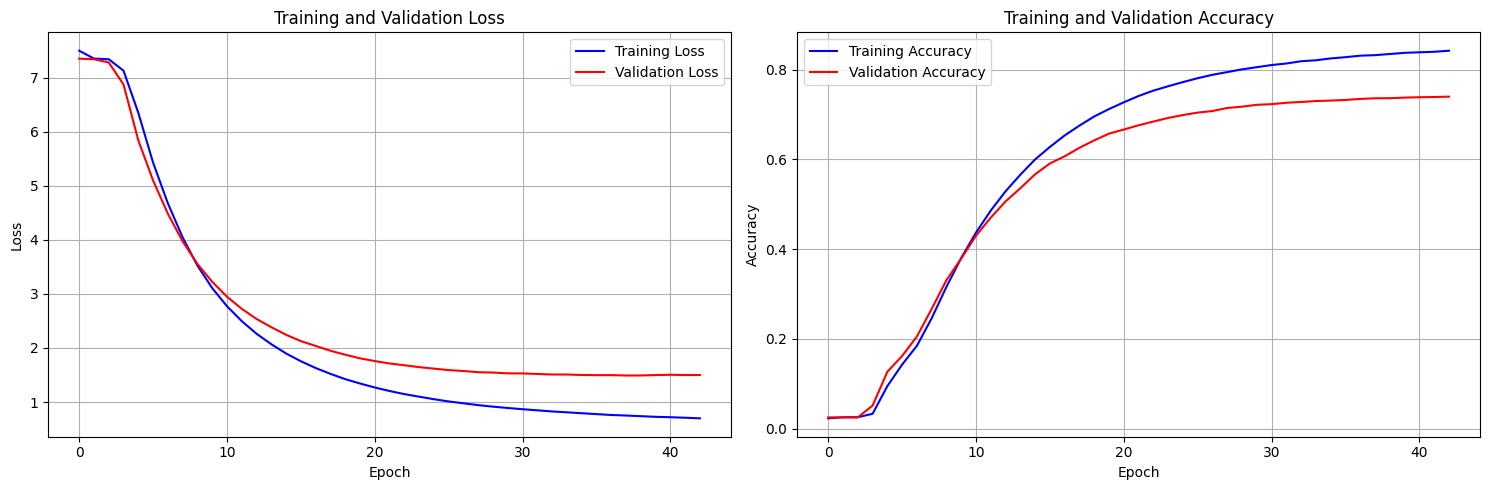


TESTING PREDICTIONS

Input: 'Sabar ka phal  '
Predictions:
  chahiye,: 0.496
  meetha: 0.452
  khana.: 0.027
  thori: 0.006
  seekh: 0.005

Input: 'Allah behtar  '
Predictions:
  janta: 0.813
  kare,: 0.036
  karega: 0.020
  karo.: 0.020
  ho: 0.017

Input: 'Mujhy kl sy neend '
Predictions:
  na: 0.956
  nahi: 0.015
  tak: 0.011
  hi: 0.005
  dekh: 0.002

Input: 'Assalam '
Predictions:
  o: 0.987
  farma,: 0.002
  de.: 0.001
  do.: 0.001
  ke: 0.001

Input: 'Subah'
Predictions:
  naha: 0.222
  insta: 0.170
  subah: 0.147
  se: 0.092
  ki: 0.076


In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Scale batch size based on GPUs
num_gpus = torch.cuda.device_count() if torch.cuda.is_available() else 1
scaled_batch_size = 1024 * max(1, num_gpus)

model, word_to_idx, idx_to_word = train(lines, device, epochs=100, 
                                       batch_size=scaled_batch_size, validation_split=0.2)

# Test predictions
print("\n" + "="*50)
print("TESTING PREDICTIONS")
print("="*50)

test_phrases = [
    "Sabar ka phal  ",
    "Allah behtar  ",
    "Mujhy kl sy neend ",
    "Assalam ",
    "Subah"
]

for phrase in test_phrases:
    predictions = predict_next_word(phrase,model,word_to_idx,device,idx_to_word=idx_to_word,top_k=5)
    print(f"\nInput: '{phrase}'")
    print("Predictions:")
    for word, prob in predictions:
        print(f"  {word}: {prob:.3f}")

In [31]:
save_model('/kaggle/working/Roman_urdu_predictor.pth',model,word_to_idx,idx_to_word,12653, embedding_dim=256,hidden_dim=1024,num_layers=3,dropout=0.3,max_sequence_length=20 )

✅ Model saved to /kaggle/working/Roman_urdu_predictor.pth


In [34]:
predict_next_word('Apna naam ',model,word_to_idx,device,idx_to_word,top_k=3)

[('bataiye.', 0.37013569474220276),
 ('bana', 0.2781078815460205),
 ('bare', 0.20148932933807373)]

In [85]:
text='''Google Pixel phones consistently receive positive reviews for their camera capabilities, software updates, and AI features. The Pixel 9, in particular, is praised for its bright screen, fast processor, and all-day battery life according to Wirecutter. The Pixel 9a offers a great value, with a top-tier chip, long battery life, and a class-leading camera. The Pixel 9 Pro and Pro XL are considered flagship-level with more features and better build quality.
Here's a more detailed look at the common themes in reviews:
Positive aspects:
Camera:
Pixel phones, especially the Pixel 9 and 9a, consistently receive high marks for their camera quality, producing sharp, natural-looking photos even in low light.
Software:
Google's software updates and AI features, like "Add Me" and "Now Playing," are praised for making life easier and more convenient.
Battery life:
Many reviewers report that Pixel phones, especially the Pro models, offer all-day battery life.
Value:
The Pixel 9a, in particular, is lauded for being a top-tier phone at a mid-range price, offering a quality experience for less.
Display:
The bright OLED displays on Pixel phones are well-regarded.
AI features:
The Pixel 9 and 9 Pro are praised for their AI capabilities, including Gemini Live and other features that streamline various tasks.
Areas for improvement:
Charging speed:
While battery life is generally good, some reviewers wish for faster charging speeds, as Google's phones don't support the fastest charging speeds offered by competitors like OnePlus.
Volume:
Some reviewers find the speakers to be on the quieter side, not reaching the volume levels of some other phones.
Design:
While the Pixel 9a offers a quality experience, some find its design to be generic.
Potential issues:
Some reviewers mention that there's a higher likelihood of issues with Pixels, potentially due to their frequent software updates or hardware choices.
Gemini vs. Google Assistant:
Some users have found the new Gemini AI assistant to be clunky, with Google Assistant still being preferable for certain tasks.'''

In [22]:
import pandas as pd

df=pd.read_csv('/kaggle/input/refined/Refined_one.csv')
df

,refined_roman_sentences
0,Tum kahan jaa rahe ho aaj kal?
1,"Mujhe bhook lagi hai, kuch khana hai."
2,"Aaj mausam bohat acha hai, kya khayal hai?"
3,"Kal tumhara paper hai, tayyari ho gayi?"
4,"Abbu ghar abhi tak nahi aaye, kya hua?"
...,...
6766,Apne talents ko discover karne ki koshish karo.
6767,Apni passions ko pura karne ki koshish karo.
6768,Apne interests ko explore karne ki koshish karo.
6769,Apne perspectives ko gain karne ki koshish karo.


In [23]:
data=df['refined_roman_sentences'].to_list()
len(data)
data[:3]

['Tum kahan jaa rahe ho aaj kal?',
 'Mujhe bhook lagi hai, kuch khana hai.',
 'Aaj mausam bohat acha hai, kya khayal hai?']

In [24]:
len(data)

6771

In [25]:
lines = ' '.join(str(x) for x in data if isinstance(x, str) or not pd.isna(x))


In [26]:
lines[:50]

'Tum kahan jaa rahe ho aaj kal? Mujhe bhook lagi ha'

In [27]:
len(lines)

489835

In [28]:
create_sequences(lines[200:250])

[['alaikum,', 'aap'],
 ['aap', 'kaise'],
 ['alaikum,', 'aap', 'kaise'],
 ['kaise', 'hain,'],
 ['aap', 'kaise', 'hain,'],
 ['alaikum,', 'aap', 'kaise', 'hain,'],
 ['hain,', 'kya'],
 ['kaise', 'hain,', 'kya'],
 ['aap', 'kaise', 'hain,', 'kya'],
 ['alaikum,', 'aap', 'kaise', 'hain,', 'kya'],
 ['kya', 'haal'],
 ['hain,', 'kya', 'haal'],
 ['kaise', 'hain,', 'kya', 'haal'],
 ['aap', 'kaise', 'hain,', 'kya', 'haal'],
 ['alaikum,', 'aap', 'kaise', 'hain,', 'kya', 'haal'],
 ['kya', 'haal', 'hai?'],
 ['aap', 'kaise', 'hain,', 'kya', 'haal', 'hai?'],
 ['alaikum,', 'aap', 'kaise', 'hain,', 'kya', 'haal', 'hai?'],
 ['kaise', 'hain,', 'kya', 'haal', 'hai?'],
 ['haal', 'hai?'],
 ['hai?', 'aap'],
 ['haal', 'hai?', 'aap'],
 ['hain,', 'kya', 'haal', 'hai?', 'aap'],
 ['kya', 'haal', 'hai?', 'aap'],
 ['alaikum,', 'aap', 'kaise', 'hain,', 'kya', 'haal', 'hai?', 'aap'],
 ['kya', 'haal', 'hai?', 'aap', 'ka'],
 ['hain,', 'kya', 'haal', 'hai?', 'aap', 'ka'],
 ['haal', 'hai?', 'aap', 'ka'],
 ['aap', 'ka'],
 ['h

In [ ]:
len(lines)

1989512

In [34]:
len(lines)

321001